# ColPali: Generate your own similarity maps 👀

[![Colab](https://img.shields.io/badge/Open_in_Colab-F9AB00?logo=googlecolab&logoColor=fff&style=for-the-badge)](https://colab.research.google.com/github/tonywu71/colpali-cookbooks/blob/main/examples/gen_colpali_similarity_maps.ipynb)
[![GitHub](https://img.shields.io/badge/ColPali_Cookbooks-100000?style=for-the-badge&logo=github&logoColor=white)](https://github.com/tonywu71/colpali-cookbooks)
[![arXiv](https://img.shields.io/badge/arXiv-2407.01449-b31b1b.svg?style=for-the-badge)](https://arxiv.org/abs/2407.01449)
[![Hugging Face](https://img.shields.io/badge/Vidore-FFD21E?style=for-the-badge&logo=huggingface&logoColor=000)](https://huggingface.co/vidore)
[![X](https://img.shields.io/badge/Thread-%23000000?style=for-the-badge&logo=X&logoColor=white)](https://x.com/tonywu_71/status/1809183824464560138)

## Introduction

With our new model *ColPali*, we propose to leverage VLMs to construct efficient multi-vector embeddings in the visual space for document retrieval. By feeding the ViT output patches from PaliGemma-3B to a linear projection, we create a multi-vector representation of documents. We train the model to maximize the similarity between these document embeddings and the query embeddings, following the ColBERT method.

ColPali is also highly interpretable: similarity maps can be obtained between patches and query tokens. These maps highlight ColPali’s strong OCR capabilities and chart understanding.

![Similarity map examples](https://github.com/tonywu71/colpali-cookbooks/blob/main/assets/interpretability/similarity_maps.jpeg?raw=true)

The following notebook guide you through how to generate your own similarity maps. You can run it on Colab (using the free-tier L4) or locally (tested on a M2 Pro Mac).


## Login to a HuggingFace account

Because ColPali uses the [PaliGemma3B](https://huggingface.co/google/paligemma-3b-mix-448) checkpoints, you need to accept its terms and conditions before using it. Once accepted, use the following cell to login to your HuggingFace account.

In [1]:
!pip install -q -U huggingface_hub
from huggingface_hub import notebook_login

notebook_login()

## Imports

This notebook leverages the [`vidore-benchmark`](https://github.com/illuin-tech/vidore-benchmark), the official evaluation package for the ViDoRe benchmark. The package also contains the necessary code to generate similarity maps.

In [2]:
!pip install -q -U "vidore-benchmark[interpretability]>=4.0.0,<5.0.0"

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 104.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 22.9 MB/s eta 0:00:00
   ━━━

In [3]:
import pprint
from pathlib import Path
from typing import cast

import torch
from colpali_engine.models import ColPali, ColPaliProcessor
from colpali_engine.utils.torch_utils import get_torch_device
from einops import rearrange
from PIL import Image
from vidore_benchmark.interpretability.plot_utils import plot_similarity_heatmap
from vidore_benchmark.interpretability.torch_utils import (
    normalize_similarity_map_per_query_token,
)
from vidore_benchmark.interpretability.vit_configs import VIT_CONFIG
from vidore_benchmark.utils.image_utils import scale_image

## Load ColPali

Click on the followin link to open the model card for [`vidore/colpali-v1.2`](https://huggingface.co/vidore/colpali-v1.2).

In [4]:
model_name = "vidore/colpali-v1.2"
processor_name = "google/paligemma-3b-mix-448"

device = get_torch_device("auto")
print(f"Using device: {device}")

# Load the model
model = cast(
    ColPali,
    ColPali.from_pretrained(
        model_name,
        torch_dtype=torch.bfloat16,
        device_map=device,
    ),
).eval()

# Load the processor
processor = cast(ColPaliProcessor, ColPaliProcessor.from_pretrained(processor_name))

# Load the ViT config
vit_config = VIT_CONFIG[model.config.name_or_path]

Using device: cuda:0


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


adapter_config.json:   0%|          | 0.00/750 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/paligemma/configuration_paligemma.py:137: FutureWarning: The `vocab_size` attribute is deprecated and will be removed in v4.44, Please use `text_config.vocab_size` instead.
  warnings.warn(


model.safetensors.index.json:   0%|          | 0.00/66.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/862M [00:00<?, ?B/s]

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/78.6M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/40.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

## Load image from filepaths

First, upload your image in the Google Colab environment, then replace the following variable values with your own.

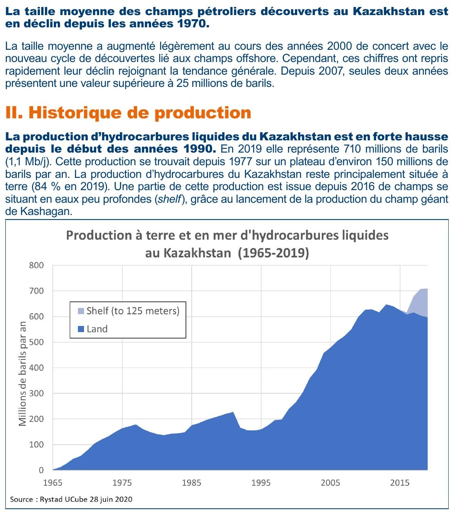

In [5]:
# ==========================     USER INPUTS     ==========================

image_filepath = Path("shift_kazakhstan.jpg")
query = "Quelle partie de la production pétrolière du Kazakhstan provient de champs en mer ?"

# =========================================================================

assert image_filepath.is_file(), f"Cannot find the image file at `{image_filepath}`"
assert query, "Please write down your query."

image = Image.open(image_filepath)

# Preview the image
scale_image(image, 512)

## Preprocess and embed both the query and the image

In [6]:
# Preprocess inputs
input_text_processed = processor.process_queries([query]).to(device)
input_image_processed = processor.process_images([image]).to(device)

# Forward passes
with torch.no_grad():
    output_text = model.forward(**input_text_processed)
    output_image = model.forward(**input_image_processed)

## Postprocess the outputs for the visualization step

In [7]:
# Remove the special tokens from the output
output_image = output_image[:, : processor.image_seq_length, :]  # (1, n_patches_x * n_patches_y, dim)

# Rearrange the output image tensor to explicitly represent the 2D grid of patches
output_image = rearrange(
    output_image, "b (h w) c -> b h w c", h=vit_config.n_patch_per_dim, w=vit_config.n_patch_per_dim
)  # (1, n_patches_x, n_patches_y, dim)

## Get the per-token similarity maps

First step is to compute all the similarity scores between the query tokens and the image patches. Then, we reshape the resulting tensor to make the image structure appear clearly in the tensor shape.

In [8]:
# Get the similarity map
similarity_map = torch.einsum(
    "bnk,bijk->bnij", output_text, output_image
)  # (1, query_tokens, n_patches_x, n_patches_y)

# Normalize the similarity map
similarity_map_normalized = normalize_similarity_map_per_query_token(
    similarity_map
)  # (1, query_tokens, n_patches_x, n_patches_y)

The following cell will display the tokens of the query. For clarity, we will ask the user to select the token for which they want to visualize the similarity map.

In [9]:
# Use this cell output to choose a token using its index
query_tokens = processor.tokenizer.tokenize(processor.decode(input_text_processed.input_ids[0]))

pprint.pprint({idx: val for idx, val in enumerate(query_tokens)})

{0: '<bos>',
 1: 'Question',
 2: ':',
 3: '▁Quelle',
 4: '▁partie',
 5: '▁de',
 6: '▁la',
 7: '▁production',
 8: '▁p',
 9: 'étro',
 10: 'lière',
 11: '▁du',
 12: '▁Kazakhstan',
 13: '▁provi',
 14: 'ent',
 15: '▁de',
 16: '▁champs',
 17: '▁en',
 18: '▁mer',
 19: '▁?',
 20: '<pad>',
 21: '<pad>',
 22: '<pad>',
 23: '<pad>',
 24: '<pad>',
 25: '<pad>',
 26: '<pad>',
 27: '<pad>',
 28: '<pad>',
 29: '<pad>',
 30: '\n'}


## Select the query token of interest

In [14]:
# Choose a token
token_idx = 12  # e.g. if "12: '▁Kazakhstan',", set 12 to choose the token 'Kazakhstan'

print(f"Selected token: `{processor.decode(input_text_processed.input_ids[0, token_idx])}`")

# Retrieve the similarity map for the chosen token
current_similarity_map = similarity_map_normalized[0, token_idx, :, :]

Selected token: ` Kazakhstan`


## Visualize the similarity map for the current query token

The brighter the patch, the higher similarity score it has with the selected token. This similarity map exhibits OCR capabilities and chart understanding of ColPali. For instance, the patch containing the selected query token should be clearly highlighted in the similarity map.

**Additional note:** You should notice a few white patches with high similarity scores. This behavior might first seem surprising as the white patches should not carry a meaningful signal from the original images. We believe the vectors associated with these patches share a similar role with the ViT registers [(Darcetet al., 2023)](https://doi.org/10.48550/arXiv.2309.16588), i.e. these patches were repurposed for internal computations and stored the global information from the whole image.

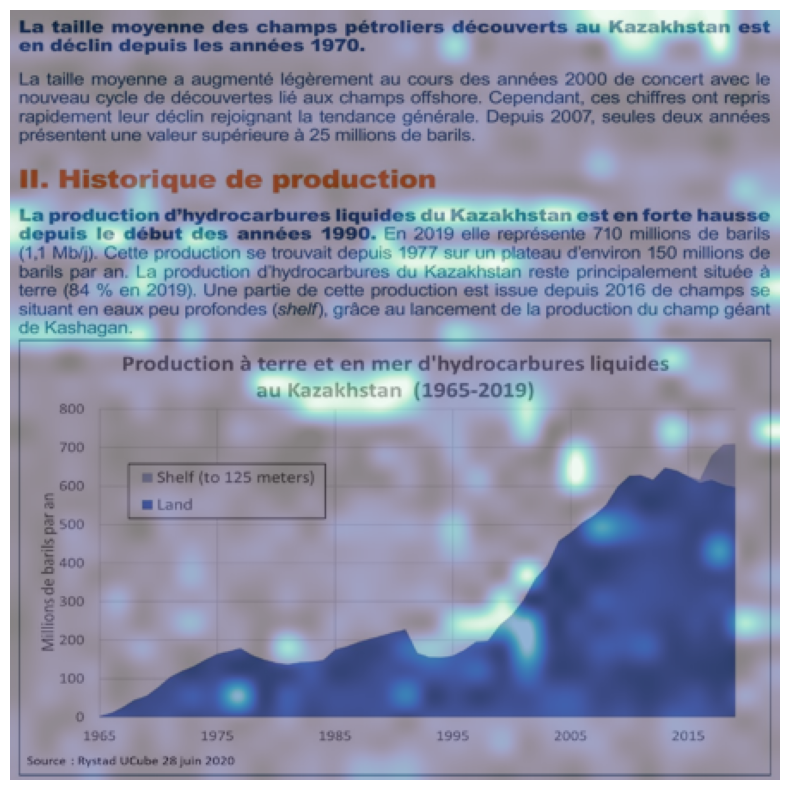

In [15]:
# Resize the image to square
input_image_square = image.resize((vit_config.resolution, vit_config.resolution))

attention_map_image = Image.fromarray(
    (similarity_map_normalized[0, token_idx, :, :].to(torch.float32).cpu().numpy() * 255).astype("uint8")
).resize(input_image_square.size, Image.Resampling.BICUBIC)

# Plot the similarity map
fig, ax = plot_similarity_heatmap(
    input_image_square,
    patch_size=vit_config.patch_size,
    image_resolution=vit_config.resolution,
    similarity_map=similarity_map_normalized[0, token_idx, :, :],
)